<a href="https://colab.research.google.com/github/coder-zmz/DM-Final/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_geometric

In [3]:
!git clone https://github.com/coder-zmz/DM-Final.git

fatal: destination path 'DM-Final' already exists and is not an empty directory.


In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [89]:
import random
import numpy as np
import torch

# 设置随机种子
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # 如果使用 GPU
torch.cuda.manual_seed_all(seed)  # 如果使用多个 GPU
torch.backends.cudnn.deterministic = True  # 保证 cuDNN 的确定性行为
torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基准测试，以保证确定性

# 文本特征提取

In [6]:
import warnings
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

# 定义一个用于文本预处理的类，继承自 CountVectorizer 的 tokenizer 参数
class LemmaTokenizer:
    """
    用于文本预处理的类，进行词形还原和简单的过滤。
    """
    def __init__(self):
        # 初始化 WordNetLemmatizer 对象，用于词形还原
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        words = []  # 初始化一个空列表，用于存储预处理后的单词
        for t in word_tokenize(doc):  # 使用 word_tokenize 对文本进行分词
            # 过滤掉长度小于 3、包含撇号或波浪号的单词
            if len(t) < 3 or "'" in t or "~" in t:
                continue
            # 对剩余的单词进行词形还原，并将结果添加到 words 列表中
            words.append(self.wnl.lemmatize(t))
        return words  # 返回预处理后的单词列表

# CountVectorizer 参数
params_count = {
    'analyzer': 'word',     # 取值'word'-分词结果为词级、'char'-字符级(结果会出现he is，空格在中间的情况)、'char_wb'-字符级(以单词为边界)，默认值为'word'
    'binary': False,        # boolean类型，设置为True，则所有非零计数都设置为1.（即，tf的值只有0和1，表示出现和不出现）
    'decode_error': 'strict',
    'dtype': np.float64,    # 输出矩阵的数值类型
    'encoding': 'utf-8',
    'input': 'content',     # 取值filename，文本内容所在的文件名；file，序列项必须有一个'read'方法，被调用来获取内存中的字节；content，直接输入文本字符串
    'lowercase': True,      # boolean类型，计算之前是否将所有字符转换为小写。
    'max_df': 0.8,          # 词汇表中忽略文档频率高于该值的词；取值在[0,1]之间的小数时表示文档频率的阈值，取值为整数时(>1)表示文档频数的阈值；如果设置了vocabulary，则忽略此参数。
    'min_df': 0.01,            # 词汇表中忽略文档频率低于该值的词；取值在[0,1]之间的小数时表示文档频率的阈值，取值为整数时(>1)表示文档频数的阈值；如果设置了vocabulary，则忽略此参数。
    'max_features': None,   # int或None(默认值).设置int值时建立一个词汇表，仅用词频排序的前max_features个词创建语料库；如果设置了vocabulary，则忽略此参数。
    'ngram_range': (1, 2),  # 要提取的n-grams中n值范围的下限和上限，min_n <= n <= max_n。
    'preprocessor': None,   # 覆盖预处理（字符串转换）阶段，同时保留标记化和 n-gram 生成步骤。仅适用于analyzer不可调用的情况。
    'stop_words': 'english',    # 仅适用于analyzer='word'。取值english，使用内置的英语停用词表；list，自行设置停停用词列表；默认值None，不会处理停用词
    'strip_accents': None,
    'token_pattern': '(?u)\\b\\w\\w+\\b',   # 分词方式、正则表达式，默认筛选长度>=2的字母和数字混合字符（标点符号被当作分隔符）。仅在analyzer='word'时使用。
    'tokenizer': LemmaTokenizer(),      # 覆盖字符串标记化步骤，同时保留预处理和 n-gram 生成步骤。仅适用于analyzer='word'
    'vocabulary': None,     # 自行设置词汇表（可设置字典），如果没有给出，则从输入文件/文本中确定词汇表
}
# tfidf 参数
params_tfidf = {
    'norm': 'l2',           # 输出结果是否标准化/归一化。l2：向量元素的平方和为1，当应用l2范数时，两个向量之间的余弦相似度是它们的点积；l1：向量元素的绝对值之和为1
    'smooth_idf': True,     # 在文档频率上加1来平滑 idf ，避免分母为0
    'sublinear_tf': True,  # 应用次线性 tf 缩放，即将 tf 替换为 1 + log(tf)
    'use_idf': True,        # 是否计算idf，布尔值，False时idf=1。
}

def text_embedding(data):
    """
    将输入的文本数据转换为文本嵌入向量，使用词袋模型和 TF-IDF 技术。

    Args:
        data: 输入文本数据，可以是字符串列表或其他可迭代对象。

    Returns:
        文本嵌入向量，以 NumPy 数组的形式返回。
    """

    # 创建 CountVectorizer 对象，并使用 params_count 中的参数进行配置
    cv = CountVectorizer(**params_count)
    # 使用 CountVectorizer 拟合数据并转换文本
    x_cv = cv.fit_transform(data)

    # 获取特征词列表
    vocabulary = cv.get_feature_names_out()
    # 打印特征词列表
    #print(f"特征词列表：\n{vocabulary}")
    # 打印词频矩阵
    #print(f"词频矩阵：\n{x_cv.toarray()}")


    # 创建 TfidfTransformer 对象，并使用 params_tfidf 中的参数进行配置
    tt = TfidfTransformer(**params_tfidf)
    # 使用 TfidfTransformer 拟合数据并转换文本
    x_tfidf = tt.fit_transform(x_cv.toarray())
    # 打印 TF-IDF 矩阵
    #print(f"TF-IDF 矩阵：\n{x_tfidf.toarray()}")

    # 返回 TF-IDF 矩阵作为文本嵌入向量
    return x_tfidf.toarray()

In [7]:
# 测试
train_data = ["Chinese Beijing Chinese ",
        "Chinese Chinese Shanghai",
        "Chinese Macao",
        "Tokyo Japan Chinese"]
print(text_embedding(train_data))

[[0.57735027 0.57735027 0.57735027 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.         0.         0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.         0.70710678 0.
  0.         0.         0.70710678 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.5        0.         0.         0.5        0.5       ]]


# 读取数据

In [8]:
import torch
from torch_geometric.data import Data

def read_data(dataset_name):
    """
    读取cora数据集，并将其转换为torch_geometric的数据格式。

    Args:
        dataset_name: 数据集名称，例如"cora"。

    Returns:
        一个torch_geometric的Data对象，包含节点特征、边索引和节点标签。
        label_name_dict: 标签对应名称的字典。
    """
    # 定义文件路径
    base_path = "/content/DM-Final/data_2/"
    edge_path = base_path + dataset_name + ".edge"
    label_path = base_path + dataset_name + ".label"
    label_name_path = base_path + dataset_name + ".label_name"
    text_path = base_path + dataset_name + ".text"

    # 读取标签对应名称
    label_name_dict = {}
    with open(label_name_path, 'r') as f:
        for line in f:
            label, name = line.strip().split(" ", 1)
            label_name_dict[int(label)] = name

    # 读取边信息
    edges = []
    with open(edge_path, 'r') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))

    # 将边信息转换为PyTorch张量
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # 读取节点标签
    labels = {}
    with open(label_path, 'r') as f:
        for line in f:
            node_id, label = map(int, line.strip().split())
            labels[node_id] = label

    # 将节点标签转换为PyTorch张量
    y = torch.tensor([labels[i] for i in range(len(labels))], dtype=torch.long)

    # 读取文本特征
    node_texts = {}
    with open(text_path, "r") as f:
        for line in f:
            node_id, text = line.strip().split(" ", 1)  # 以第一个空格分割
            node_texts[int(node_id)] = text

    # 获取节点特征
    node_features = text_embedding(list(node_texts.values()))
    x = torch.tensor(node_features, dtype=torch.float32)

    # 创建Data对象
    data = Data(x=x, edge_index=edge_index, y=y)

    return data, label_name_dict

In [9]:
# 读取cora数据集
cora_data = read_data("cora")
data = cora_data[0]
# 验证数据集
data.validate()

# 获取数据集的类别数量
cora_classes = len(torch.unique(data.y))

# 检查 data.x 的最小值和最大值
min_val = torch.min(data.x)
max_val = torch.max(data.x)

print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")

print(f"data.x.shape: {data.x.shape}")
print(f"data.edge_index.shape: {data.edge_index.shape}")
print(f"data.y.shape: {data.y.shape}")

Minimum value: 0.0
Maximum value: 1.0
data.x.shape: torch.Size([2708, 1150])
data.edge_index.shape: torch.Size([2, 10858])
data.y.shape: torch.Size([2708])


In [10]:
import torch
import numpy as np

# 假设 data.y 是你的节点标签张量
unique_labels, label_counts = torch.unique(data.y, return_counts=True)

# 将结果转换为 NumPy 数组
unique_labels = unique_labels.cpu().numpy()
label_counts = label_counts.cpu().numpy()

for label, count in zip(unique_labels, label_counts):
    label_name = cora_data[1].get(label)
    print(f"类别 {label_name} : {count} 个节点")

类别 Rule_Learning : 180 个节点
类别 Neural_Networks : 818 个节点
类别 Case_Based : 298 个节点
类别 Genetic_Algorithms : 418 个节点
类别 Theory : 351 个节点
类别 Reinforcement_Learning : 217 个节点
类别 Probabilistic_Methods : 426 个节点


# 数据预处理

## 降维

In [11]:
from sklearn.decomposition import PCA

# 创建 PCA 对象，指定降维后的维度
pca = PCA(n_components=500)

# 对特征矩阵进行降维
reduced_features = pca.fit_transform(data.x)

# 将降维后的特征转换为 PyTorch 张量
data.x = torch.tensor(reduced_features, dtype=torch.float32)

# 检查降维后的数据
data.x.shape

torch.Size([2708, 500])

## 按类别划分数据集

In [90]:
import torch
import numpy as np

def split_data(data):
    """
    每种节点选取 40 个作为训练集，并随机选择 1000 个节点作为测试集。

    Args:
        data: torch_geometric.data.Data 对象，包含节点特征、边索引和节点标签。

    Returns:
        更新后的 data 对象，包含 train_mask、val_mask 和 test_mask。
    """
    num_nodes = data.num_nodes
    unique_labels = torch.unique(data.y)  # 获取所有类别标签

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    for label in unique_labels:
        label_indices = torch.where(data.y == label)[0]  # 获取该类别所有节点的索引
        num_label_nodes = len(label_indices)

        # 训练集节点：每种类别选取 40 个
        train_idx = label_indices[torch.randperm(num_label_nodes)[:40]]
        train_mask[train_idx] = True

    # 测试集节点：随机选择 1000 个
    test_idx = torch.randperm(num_nodes)[:1000]
    test_mask[test_idx] = True

    # 其余节点作为验证集
    val_mask = ~(train_mask | test_mask)

    # 将掩码添加到 data 对象
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

In [120]:
data = split_data(data)

train_nodes = data.y[data.train_mask]  # 获取训练集节点的标签
unique_labels, label_counts = torch.unique(train_nodes, return_counts=True)  # 统计每个标签的出现次数

# 将结果转换为字典
class_counts = {label.item(): count.item() for label, count in zip(unique_labels, label_counts)}
for label, count in class_counts.items():
    print(f"类别 {label}: {count} 个节点")


类别 0: 40 个节点
类别 1: 40 个节点
类别 2: 40 个节点
类别 3: 40 个节点
类别 4: 40 个节点
类别 5: 40 个节点
类别 6: 40 个节点


# 模型训练

## 评价函数

In [160]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch

def calculate_metrics(model, data, mask):
    """
    计算模型在指定数据集上的所有指标。

    Args:
        model: 模型。
        data: 数据对象。
        mask: 用于选择节点的掩码，例如 data.train_mask 或 data.test_mask。

    Returns:
        一个包含所有指标的字典。
    """
    model.eval()
    with torch.no_grad():  # 禁用梯度计算
      out = model(data.x, data.edge_index)
      probs = torch.nn.functional.softmax(out, dim=1) # 使用 softmax 将模型输出转换为概率
      pred = out.argmax(dim=1).cpu().numpy()  # 获取预测类别
      true = data.y[mask].cpu().numpy()  # 获取真实标签

      # 计算指标
      acc = accuracy_score(true, pred[mask])
      prec = precision_score(true, pred[mask], average='weighted')
      rec = recall_score(true, pred[mask], average='weighted')
      f1 = f1_score(true, pred[mask], average='weighted')
      auc = roc_auc_score(true, probs[mask].cpu().detach().numpy(), multi_class='ovr', average='weighted')

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

## 训练函数

In [138]:
import pandas as pd
import torch
from tqdm import tqdm

def train_and_evaluate(model, criterion, optimizer, data, num_epochs=200, patience=10, scheduler=None):
    """
    训练模型并评估其在训练集和测试集上的性能。

    Args:
        model: PyTorch 模型。
        criterion: 损失函数。
        optimizer: 优化器。
        data: PyTorch Geometric 数据对象。
        num_epochs: 训练轮数。
        patience: 早停的 patience 值，即连续多少个 epoch 验证集损失没有下降就停止训练。
        scheduler: 学习率调度器(可选)。

    Returns:
        train_metrics_df: 存储训练集上评价指标的 Pandas DataFrame。
        test_metrics_df: 存储测试集上评价指标的 Pandas DataFrame。
    """

    # 创建 Pandas DataFrame
    train_metrics_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1', 'auc'])
    test_metrics_df = pd.DataFrame(columns=['epoch', 'accuracy', 'precision', 'recall', 'f1', 'auc'])

    # 初始化早停计数器和最佳验证集损失
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 训练循环
    for epoch in tqdm(range(1, num_epochs + 1)):
        # 训练模型
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # 计算验证集上的Loss
        model.eval()
        with torch.no_grad(): # 禁用梯度计算
          out = model(data.x, data.edge_index)
          val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        # 检查验证集损失是否下降
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # 如果提供了 scheduler，则更新学习率
        if scheduler is not None:
            scheduler.step(val_loss)

        # 每 20 个 epoch 评估模型性能
        if epoch % 20 == 0 or early_stop_counter >= patience:

            # 计算训练集上的评价指标
            train_metrics = calculate_metrics(model, data, data.train_mask)
            # 计算测试集上的评价指标
            test_metrics = calculate_metrics(model, data, data.test_mask)

            # 将指标添加到 DataFrame
            train_metrics_df.loc[len(train_metrics_df)] = [epoch, loss.item(), train_metrics['accuracy'], train_metrics['precision'], train_metrics['recall'], train_metrics['f1'], train_metrics['auc']]
            test_metrics_df.loc[len(test_metrics_df)] = [epoch, test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1'], test_metrics['auc']]

            # 打印指标
            """
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Acc: {train_metrics["accuracy"]:.4f}, Train Prec: {train_metrics["precision"]:.4f}, Train Rec: {train_metrics["recall"]:.4f}, Train F1: {train_metrics["f1"]:.4f}, Train AUC: {train_metrics["auc"]:.4f}, '
                  f'Test Acc: {test_metrics["accuracy"]:.4f}, Test Prec: {test_metrics["precision"]:.4f}, Test Rec: {test_metrics["recall"]:.4f}, Test F1: {test_metrics["f1"]:.4f}, Test AUC: {test_metrics["auc"]:.4f}')
            """

            # 如果验证集损失连续 patience 个 epoch 没有下降，则停止训练
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

    return train_metrics_df, test_metrics_df

## CORA+GCN

In [192]:
# @title 默认
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # 对输入的节点特征 x 进行 Dropout 操作，以减少过拟合风险。
        # p=0.5 表示丢弃概率为0.5，即有50%的概率将输入置零。
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return h

model = GCN(hidden_channels=16)
print(model)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.01, weight_decay=5e-4)

# 训练并评估模型
cora_train_metrics_default, cora_test_metrics_default = train_and_evaluate(model, criterion, optimizer, data, 500)

print(f"训练集指标:\n{cora_train_metrics_default}")
print(f"测试集指标:\n{cora_test_metrics_default}")

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 7)
)


 42%|████▏     | 208/500 [00:09<00:12, 22.74it/s]

Early stopping at epoch 209
训练集指标:
    epoch      loss  accuracy  precision    recall        f1       auc
0    20.0  1.500400  0.910714   0.914031  0.910714  0.911526  0.990491
1    40.0  0.837234  0.953571   0.956951  0.953571  0.953800  0.997946
2    60.0  0.470190  0.978571   0.979260  0.978571  0.978515  0.999568
3    80.0  0.288454  0.992857   0.993031  0.992857  0.992856  0.999985
4   100.0  0.217204  1.000000   1.000000  1.000000  1.000000  1.000000
5   120.0  0.208301  1.000000   1.000000  1.000000  1.000000  1.000000
6   140.0  0.156159  1.000000   1.000000  1.000000  1.000000  1.000000
7   160.0  0.168010  1.000000   1.000000  1.000000  1.000000  1.000000
8   180.0  0.150709  1.000000   1.000000  1.000000  1.000000  1.000000
9   200.0  0.151703  1.000000   1.000000  1.000000  1.000000  1.000000
10  209.0  0.141011  1.000000   1.000000  1.000000  1.000000  1.000000
测试集指标:
    epoch  accuracy  precision  recall        f1       auc
0    20.0     0.742   0.773340   0.742  0.74317

Text(0, 0.5, 'Accuracy')

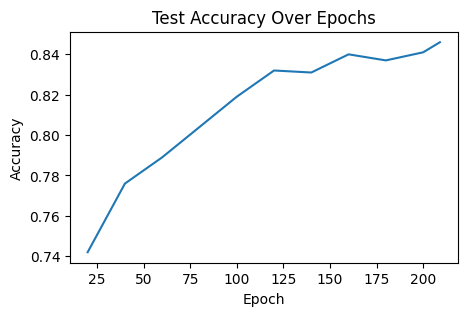

In [193]:
# 可视化测试集指标
import matplotlib.pyplot as plt

# 准确率曲线
plt.figure(figsize=(5, 3))
plt.plot(cora_test_metrics_default['epoch'], cora_test_metrics_default['accuracy'])
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [203]:
# @title 网格搜索
from sklearn.model_selection import ParameterGrid
import torch
import pandas as pd

def gcn_grid_search_single_run(data, param_grid, num_epochs=200, target_accuracy=0.9):
    """
    使用网格搜索来优化 GCN 模型。

    Args:
        data: PyTorch Geometric 数据对象。
        param_grid: 超参数空间字典。
        num_epochs: 训练轮数。
        target_accuracy: 目标准确率，达到目标值时停止搜索。

    Returns:
        results_df: 包含所有网格搜索结果的 DataFrame。
    """

    results = []  # 用于存储结果的列表

    # 遍历超参数空间中的所有组合
    for params in ParameterGrid(param_grid):
        print(f"Testing with params: {params}")

        # 创建模型、损失函数和优化器
        model = GCN(hidden_channels=params['hidden_channels'])
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # 训练模型
        cora_train_metrics_df, cora_test_metrics_df = train_and_evaluate(model, criterion, optimizer, data, 300)

        # 计算验证集上的分数 (例如，准确率)
        val_score = calculate_metrics(model, data, data.val_mask)['accuracy']
        print(f"Validation accuracy: {val_score:.4f}")

        # 将结果添加到列表中
        results.append({**params, 'accuracy': val_score})  # 使用 **params 将字典解包

        # 检查准确率是否达到目标值
        if val_score >= target_accuracy:
            best_params = params
            print(f"Target accuracy reached! Stopping search with best params: {best_params}")
            break  # 停止搜索

    # 将结果转换为 DataFrame
    results_df = pd.DataFrame(results)

    return results_df

param_grid = {
    'hidden_channels': [16, 32, 64],
    'lr': [0.1, 0.05, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'dropout': [0.3, 0.5]
}

# 调用函数进行网格搜索
results_df = gcn_grid_search_single_run(data, param_grid, 200, 0.86)

Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.0005}


 14%|█▍        | 42/300 [00:01<00:07, 34.60it/s]


Early stopping at epoch 43
Validation accuracy: 0.8468
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.001}


 10%|█         | 30/300 [00:00<00:06, 43.30it/s]


Early stopping at epoch 31
Validation accuracy: 0.8442
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.005}


 10%|█         | 31/300 [00:00<00:06, 44.60it/s]


Early stopping at epoch 32
Validation accuracy: 0.8462
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 15%|█▌        | 46/300 [00:03<00:18, 13.91it/s]


Early stopping at epoch 47
Validation accuracy: 0.8487
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 19%|█▉        | 58/300 [00:02<00:09, 25.98it/s]


Early stopping at epoch 59
Validation accuracy: 0.8397
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 15%|█▌        | 45/300 [00:04<00:25, 10.07it/s]


Early stopping at epoch 46
Validation accuracy: 0.8513
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 67%|██████▋   | 200/300 [00:10<00:05, 19.61it/s]


Early stopping at epoch 201
Validation accuracy: 0.8287
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 69%|██████▉   | 207/300 [00:14<00:06, 14.78it/s]


Early stopping at epoch 208
Validation accuracy: 0.8468
Testing with params: {'dropout': 0.3, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 49%|████▊     | 146/300 [00:07<00:08, 19.06it/s]


Early stopping at epoch 147
Validation accuracy: 0.8513
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.0005}


 14%|█▍        | 43/300 [00:04<00:24, 10.41it/s]


Early stopping at epoch 44
Validation accuracy: 0.8384
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.001}


  9%|▊         | 26/300 [00:00<00:09, 29.62it/s]


Early stopping at epoch 27
Validation accuracy: 0.8455
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.005}


  9%|▉         | 27/300 [00:01<00:10, 26.80it/s]


Early stopping at epoch 28
Validation accuracy: 0.8429
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


 14%|█▎        | 41/300 [00:02<00:18, 14.24it/s]


Early stopping at epoch 42
Validation accuracy: 0.8481
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


 17%|█▋        | 51/300 [00:03<00:15, 15.63it/s]


Early stopping at epoch 52
Validation accuracy: 0.8429
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


 12%|█▏        | 37/300 [00:03<00:21, 12.25it/s]


Early stopping at epoch 38
Validation accuracy: 0.8449
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 51%|█████▏    | 154/300 [00:09<00:09, 15.88it/s]


Early stopping at epoch 155
Validation accuracy: 0.8403
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 51%|█████     | 152/300 [00:09<00:08, 16.82it/s]


Early stopping at epoch 153
Validation accuracy: 0.8487
Testing with params: {'dropout': 0.3, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 37%|███▋      | 111/300 [00:10<00:17, 10.73it/s]


Early stopping at epoch 112
Validation accuracy: 0.8481
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.0005}


  8%|▊         | 24/300 [00:01<00:13, 20.88it/s]


Early stopping at epoch 25
Validation accuracy: 0.8436
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.001}


  7%|▋         | 22/300 [00:01<00:14, 19.59it/s]


Early stopping at epoch 23
Validation accuracy: 0.8268
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.005}


  7%|▋         | 21/300 [00:01<00:19, 14.21it/s]


Early stopping at epoch 22
Validation accuracy: 0.8546
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.0005}


 12%|█▏        | 35/300 [00:04<00:33,  7.84it/s]


Early stopping at epoch 36
Validation accuracy: 0.8429
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.001}


 10%|█         | 31/300 [00:03<00:31,  8.59it/s]


Early stopping at epoch 32
Validation accuracy: 0.8455
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.005}


 10%|▉         | 29/300 [00:01<00:11, 22.67it/s]


Early stopping at epoch 30
Validation accuracy: 0.8442
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.0005}


 42%|████▏     | 125/300 [00:11<00:15, 11.10it/s]


Early stopping at epoch 126
Validation accuracy: 0.8390
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.001}


 31%|███▏      | 94/300 [00:07<00:17, 11.76it/s]


Early stopping at epoch 95
Validation accuracy: 0.8494
Testing with params: {'dropout': 0.3, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.005}


 23%|██▎       | 68/300 [00:04<00:15, 15.17it/s]


Early stopping at epoch 69
Validation accuracy: 0.8500
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.0005}


 12%|█▏        | 37/300 [00:03<00:23, 11.32it/s]


Early stopping at epoch 38
Validation accuracy: 0.8358
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.001}


 11%|█▏        | 34/300 [00:02<00:16, 16.27it/s]


Early stopping at epoch 35
Validation accuracy: 0.8500
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.005}


 20%|██        | 60/300 [00:03<00:12, 18.58it/s]


Early stopping at epoch 61
Validation accuracy: 0.8533
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 17%|█▋        | 50/300 [00:02<00:14, 16.98it/s]


Early stopping at epoch 51
Validation accuracy: 0.8410
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 19%|█▉        | 57/300 [00:04<00:17, 13.84it/s]


Early stopping at epoch 58
Validation accuracy: 0.8416
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 15%|█▌        | 45/300 [00:04<00:26,  9.77it/s]


Early stopping at epoch 46
Validation accuracy: 0.8468
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 67%|██████▋   | 202/300 [00:10<00:05, 19.17it/s]


Early stopping at epoch 203
Validation accuracy: 0.8287
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 71%|███████   | 212/300 [00:13<00:05, 15.37it/s]


Early stopping at epoch 213
Validation accuracy: 0.8468
Testing with params: {'dropout': 0.5, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 51%|█████▏    | 154/300 [00:05<00:05, 28.29it/s]


Early stopping at epoch 155
Validation accuracy: 0.8500
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.0005}


  9%|▉         | 28/300 [00:02<00:26, 10.28it/s]


Early stopping at epoch 29
Validation accuracy: 0.8403
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.001}


  8%|▊         | 25/300 [00:01<00:21, 12.88it/s]


Early stopping at epoch 26
Validation accuracy: 0.8423
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.005}


  8%|▊         | 25/300 [00:00<00:10, 25.25it/s]


Early stopping at epoch 26
Validation accuracy: 0.8507
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


 16%|█▌        | 48/300 [00:03<00:16, 15.72it/s]


Early stopping at epoch 49
Validation accuracy: 0.8416
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


 13%|█▎        | 39/300 [00:02<00:18, 14.06it/s]


Early stopping at epoch 40
Validation accuracy: 0.8468
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


 12%|█▏        | 37/300 [00:01<00:12, 21.57it/s]


Early stopping at epoch 38
Validation accuracy: 0.8429
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 59%|█████▊    | 176/300 [00:11<00:07, 15.65it/s]


Early stopping at epoch 177
Validation accuracy: 0.8410
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 49%|████▉     | 147/300 [00:11<00:11, 12.98it/s]


Early stopping at epoch 148
Validation accuracy: 0.8442
Testing with params: {'dropout': 0.5, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 39%|███▉      | 117/300 [00:06<00:10, 17.04it/s]


Early stopping at epoch 118
Validation accuracy: 0.8513
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.0005}


  8%|▊         | 24/300 [00:01<00:21, 12.65it/s]


Early stopping at epoch 25
Validation accuracy: 0.8442
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.001}


  7%|▋         | 21/300 [00:03<00:44,  6.25it/s]


Early stopping at epoch 22
Validation accuracy: 0.8313
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.005}


  8%|▊         | 24/300 [00:01<00:20, 13.53it/s]


Early stopping at epoch 25
Validation accuracy: 0.8500
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.0005}


 11%|█▏        | 34/300 [00:02<00:19, 13.88it/s]


Early stopping at epoch 35
Validation accuracy: 0.8449
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.001}


  9%|▉         | 27/300 [00:01<00:12, 22.13it/s]


Early stopping at epoch 28
Validation accuracy: 0.8442
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.005}


 10%|▉         | 29/300 [00:02<00:26, 10.13it/s]


Early stopping at epoch 30
Validation accuracy: 0.8481
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.0005}


 40%|███▉      | 119/300 [00:09<00:14, 12.92it/s]


Early stopping at epoch 120
Validation accuracy: 0.8410
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.001}


 37%|███▋      | 112/300 [00:10<00:17, 10.83it/s]


Early stopping at epoch 113
Validation accuracy: 0.8494
Testing with params: {'dropout': 0.5, 'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.005}


 26%|██▋       | 79/300 [00:06<00:18, 11.68it/s]

Early stopping at epoch 80
Validation accuracy: 0.8533


In [206]:
# 获取最优
best_params = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters:\n{best_params}")

Best parameters:
dropout             0.300000
hidden_channels    64.000000
lr                  0.100000
weight_decay        0.005000
accuracy            0.854557
Name: 20, dtype: float64


In [214]:
# @title 调优
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # 对输入的节点特征 x 进行 Dropout 操作，以减少过拟合风险。
        # p=0.5 表示丢弃概率为0.5，即有50%的概率将输入置零。
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.conv2(h, edge_index)
        return h

model = GCN(hidden_channels=64)
print(model)

# 定义损失函数、优化器、学习率调度器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.1, weight_decay=0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 训练并评估模型
cora_train_metrics_tuned, cora_test_metrics_tuned = train_and_evaluate(model, criterion, optimizer, data, 300, 20, scheduler)

print(f"训练集指标:\n{cora_train_metrics_tuned}")
print(f"测试集指标:\n{cora_test_metrics_tuned}")

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 7)
)


 10%|█         | 31/300 [00:01<00:12, 21.47it/s]

Early stopping at epoch 32
训练集指标:
   epoch      loss  accuracy  precision    recall        f1       auc
0   20.0  0.380484  0.967857   0.969202  0.967857  0.967924  0.999539
1   32.0  0.414172  0.964286   0.966133  0.964286  0.964380  0.999598
测试集指标:
   epoch  accuracy  precision  recall        f1       auc
0   20.0     0.847   0.864111   0.847  0.849194  0.980175
1   32.0     0.859   0.871950   0.859  0.860578  0.981300


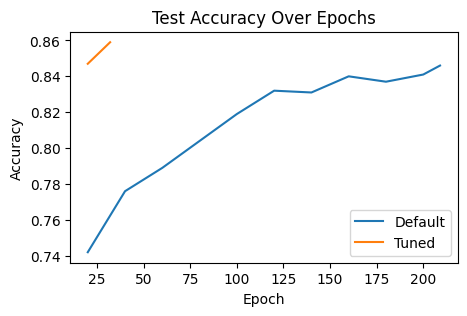

In [215]:
# 可视化
import matplotlib.pyplot as plt

# 调优后测试集上的准确率，叠加调优前的
plt.figure(figsize=(5, 3))
plt.plot(cora_test_metrics_default['epoch'], cora_test_metrics_default['accuracy'], label='Default')
plt.plot(cora_test_metrics_tuned['epoch'], cora_test_metrics_tuned['accuracy'], label='Tuned')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


## CORA+GAT

In [40]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F

# GAT 模型
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(data.num_node_features, hidden_channels, heads=8, dropout=0.6)
        # heads参数控制多头注意力机制的头数。
        # dropout参数控制dropout的比例，用于防止过拟合。
        self.conv2 = GATConv(hidden_channels * 8, len(torch.unique(data.y)),heads=1, concat=False, dropout=0.6)
        # concat参数控制是否将多头注意力的结果拼接起来，这里设置为False，表示取平均。


    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8)
print(model)

# 模型训练
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# 训练并评估模型
train_metrics_df, test_metrics_df = train_and_evaluate(model, criterion, optimizer, data, 500)

GAT(
  (conv1): GATConv(500, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 020, Train Loss: 1.6649, Val Loss: 1.7082, Train Acc: 0.9214, Train Prec: 0.9287, Train Rec: 0.9214, Train F1: 0.9215, Train AUC: 0.9932, Test Acc: 0.8230, Test Prec: 0.8320, Test Rec: 0.8230, Test F1: 0.8232, Test AUC: 0.9552
Epoch: 040, Train Loss: 1.3143, Val Loss: 1.3624, Train Acc: 0.9286, Train Prec: 0.9349, Train Rec: 0.9286, Train F1: 0.9286, Train AUC: 0.9969, Test Acc: 0.8390, Test Prec: 0.8545, Test Rec: 0.8390, Test F1: 0.8399, Test AUC: 0.9712
Epoch: 060, Train Loss: 1.0084, Val Loss: 1.0558, Train Acc: 0.9357, Train Prec: 0.9406, Train Rec: 0.9357, Train F1: 0.9357, Train AUC: 0.9982, Test Acc: 0.8520, Test Prec: 0.8637, Test Rec: 0.8520, Test F1: 0.8522, Test AUC: 0.9767
Epoch: 080, Train Loss: 0.8999, Val Loss: 0.8698, Train Acc: 0.9500, Train Prec: 0.9526, Train Rec: 0.9500, Train F1: 0.9499, Train AUC: 0.9988, Test Acc: 0.8570, Test Prec: 0.8671, Test Rec: 0.8570, Test F1: 0.8573, Tes

# 可视化

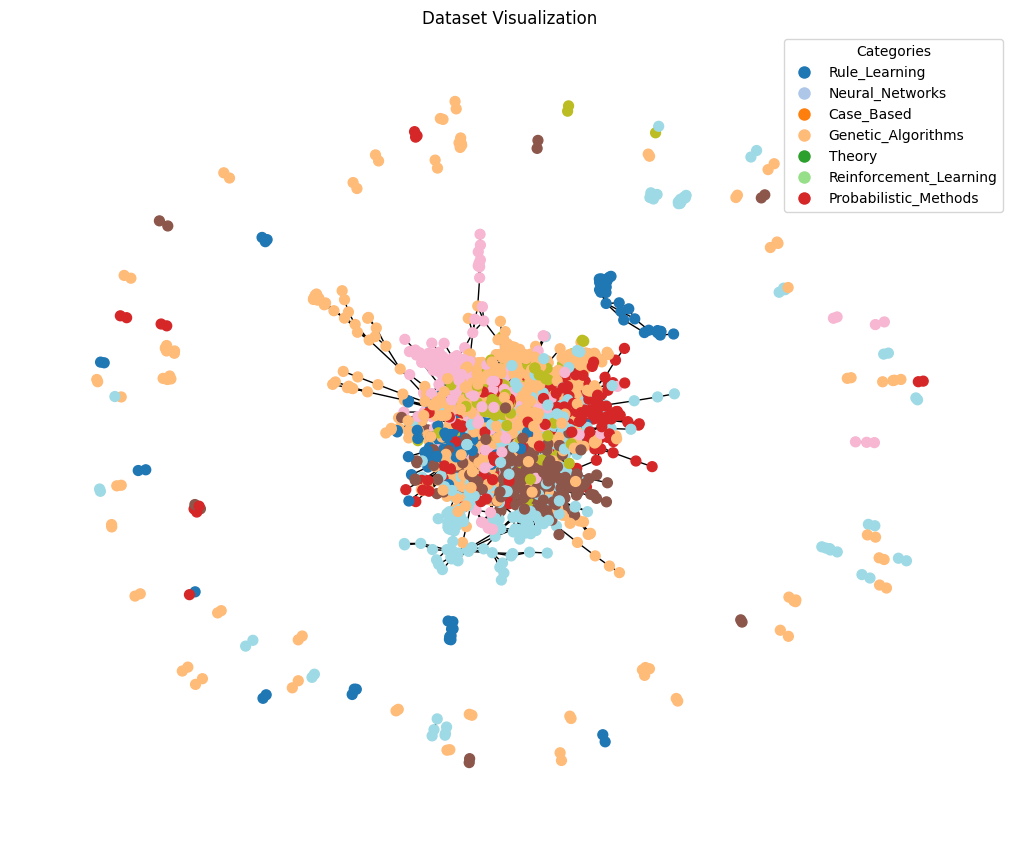

In [171]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(data, label_name_dict):
    """
    可视化图数据。

    Args:
        data: torch_geometric.data.Data 对象，包含节点特征、边索引和节点标签。
        label_name_dict: 标签对应名称的字典。
    """
    # 创建 NetworkX 图对象
    graph = nx.Graph()
    graph.add_edges_from(data.edge_index.t().numpy())

    # 将标签添加到图的节点属性中
    for i, label in enumerate(data.y.numpy()):
        graph.nodes[i]["label"] = label

    # 可视化
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # 使用 spring_layout 进行布局
    # 为每个节点设置颜色，根据其标签
    node_colors = [graph.nodes[node]["label"] for node in graph.nodes()]
    nx.draw(
        graph,
        pos,
        node_color=node_colors,
        node_size=50,
        cmap=plt.cm.tab20,
        with_labels=False,
    )

    # 添加图例
    handles = []
    for label in np.unique(node_colors):
        if label in label_name_dict:
            handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    label=label_name_dict[label],
                    markerfacecolor=plt.cm.tab20(label),
                    markersize=10,
                )
            )

    plt.legend(handles=handles, title="Categories")
    plt.title("Dataset Visualization")
    plt.show()

# 调用可视化函数
visualize_data(data, cora_data[1])

# 官方数据集获取(弃)

In [ ]:
# 数据集相关信息
'''
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="tmp", name = "Cora", transform=NormalizeFeatures())

print()
print(f"datasets:{dataset}")
print(f"num of graphs:{len(dataset)}")
print(f"num of features:{dataset.num_features}")
print(f"num of classes: {dataset.num_classes}")

data = dataset[0]

print(data)
print(f"num of nodes: {data.num_nodes}")
print(f"num of node_features: {data.num_node_features}")
print(f"num of edges: {data.num_edges}")

print(f"num of training node: {data.train_mask.sum()}")
print(f"training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
'''


datasets:Cora()
num of graphs:1
num of features:1433
num of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
num of nodes: 2708
num of node_features: 1433
num of edges: 10556
num of training node: 140
training node label rate: 0.05


In [ ]:
print(dir(dataset))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'cpu', 'cuda', 'data', 'download', 'force_reload', 'geom_gcn_url', 'get', 'get_summary', 'has_download', 'has_process', 'index_select', 'indices', 'len', 'load', 'log', 'name', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_

## 随机划分数据集(弃)

In [ ]:
num_nodes = data.num_nodes
num_train = int(0.1 * num_nodes)  # 10% 用于训练
num_val = int(0.4 * num_nodes)    # 40% 用于验证

# 随机选择训练集节点
train_idx = torch.randperm(num_nodes)[:num_train]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True

# 随机选择验证集节点
val_idx = torch.randperm(num_nodes)[num_train:num_train + num_val]
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_idx] = True

# 其余节点作为测试集
test_mask = ~(train_mask | val_mask)

# 将掩码添加到 data 对象
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [ ]:
print(data.train_mask)
print(data.val_mask)
print(data.test_mask)

tensor([False, False, False,  ..., False, False, False])
tensor([ True,  True,  True,  ..., False, False,  True])
tensor([False, False, False,  ...,  True,  True, False])
